<font size="+3"><strong>Clustering with Multiple Features</strong></font>

In [33]:
import pandas as pd
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Prepare Data

## Import

In [34]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask = (df["TURNFEAR"] == 1) & (df["NETWORTH"] < 2e6)
    df = df[mask]
    return df

In [35]:
df = wrangle("SCFP2019.csv")
print(df.shape)
df.head()

(4418, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


## Explore

In [36]:
x = df["DEBT"]
x.head()

5    12200.0
6    12600.0
7    15300.0
8    14100.0
9    15400.0
Name: DEBT, dtype: float64

In [37]:
# Calculate variance, get 10 largest features
top_ten_var = df.var().sort_values().tail(10)
top_ten_var

PLOAN1      1.140894e+10
ACTBUS      1.251892e+10
BUS         1.256643e+10
KGTOTAL     1.346475e+10
DEBT        1.848252e+10
NHNFIN      2.254163e+10
HOUSES      2.388459e+10
NETWORTH    4.847029e+10
NFIN        5.713939e+10
ASSET       8.303967e+10
dtype: float64

As usual, it's harder to make sense of a list like this than it would be if we visualized it, so let's make a graph. 

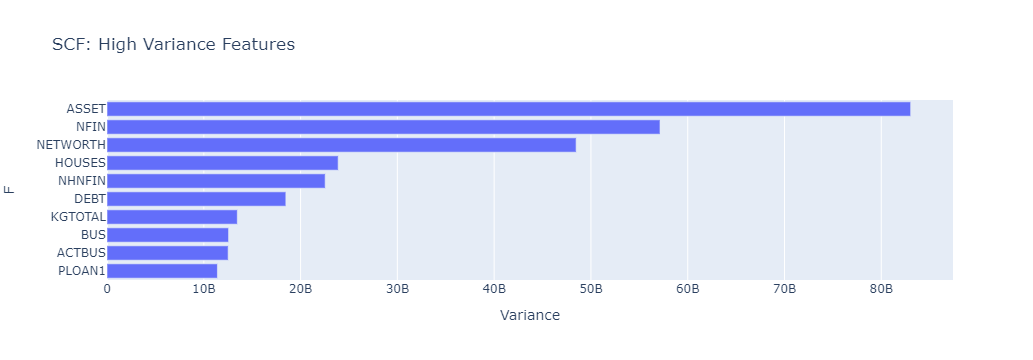

In [38]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Variance", yaxis_title="F")
fig.show()

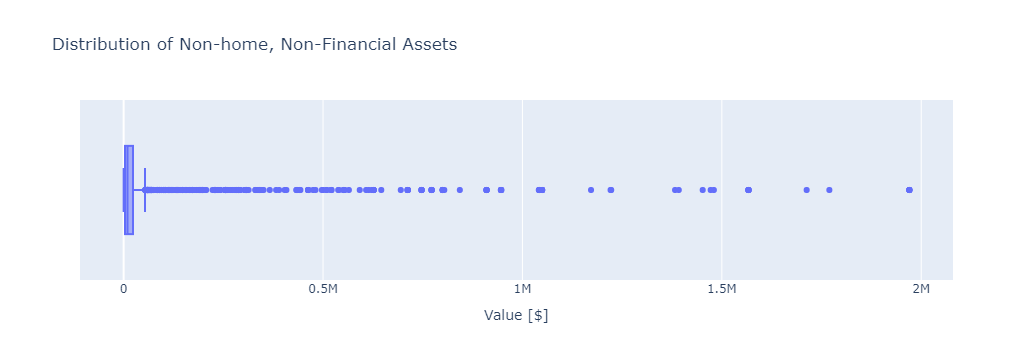

In [39]:
# Create a boxplot of `NHNFIN`
fig = px.box(
    data_frame=df,
    x="NHNFIN",
    title="Distribution of Non-home, Non-Financial Assets"
)
fig.update_layout(xaxis_title="Value [$]")
fig.show()

The dataset is massively right-skewed because of the huge outliers on the right side of the distribution. Even though we already excluded households with a high net worth with our `wrangle` function, the variance is still being distorted by some extreme outliers.

The best way to deal with this is to look at the **trimmed variance**, where we remove extreme values before calculating variance. We can do this using the `trimmed_variance` function from the `SciPy` library.

In [40]:
trimmed_var(df["DEBT"])

3089864647.655702

In [41]:
df.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)

WAGEINC     5.550737e+08
HOMEEQ      7.338377e+08
NH_MORT     1.333125e+09
MRTHEL      1.380468e+09
PLOAN1      1.441968e+09
DEBT        3.089865e+09
NETWORTH    3.099929e+09
HOUSES      4.978660e+09
NFIN        8.456442e+09
ASSET       1.175370e+10
dtype: float64

In [42]:
# Calculate trimmed variance
top_ten_trim_var = df.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)
top_ten_trim_var

WAGEINC     5.550737e+08
HOMEEQ      7.338377e+08
NH_MORT     1.333125e+09
MRTHEL      1.380468e+09
PLOAN1      1.441968e+09
DEBT        3.089865e+09
NETWORTH    3.099929e+09
HOUSES      4.978660e+09
NFIN        8.456442e+09
ASSET       1.175370e+10
dtype: float64

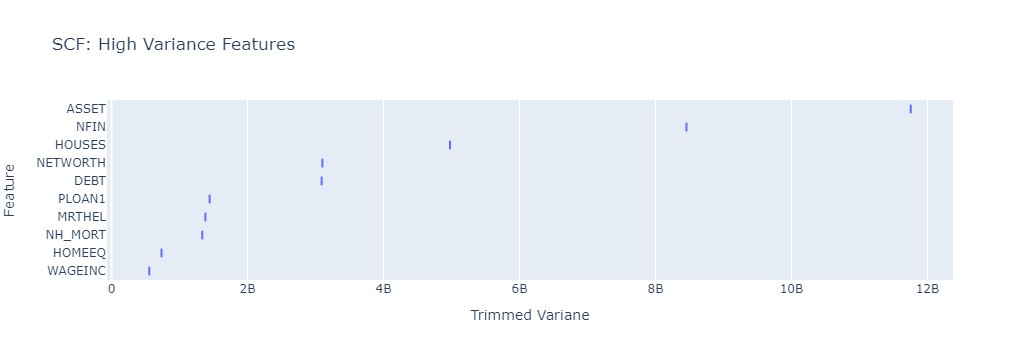

In [43]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.box(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Trimmed Variane", yaxis_title="Feature")
fig.show()

There are three things to notice in this plot. First, the variances have decreased a lot. In our previous chart, the x-axis went up to \\$80 billion; this one goes up to \\$12 billion. Second, the top 10 features have changed a bit. All the features relating to business ownership (`"...BUS"`) are gone. Finally, we can see that there are big differences in variance from feature to feature. For example, the variance for `"WAGEINC"` is around than \\$500 million, while the variance for `"ASSET"` is nearly \\$12 billion. In other words, these features have completely different scales. This is something that we'll need to address before we can make good clusters. 

In [44]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET']

## Split

In [45]:
X = df[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
5,12200.0,-6710.0,0.0,3900.0,5490.0
6,12600.0,-4710.0,0.0,6300.0,7890.0
7,15300.0,-8115.0,0.0,5600.0,7185.0
8,14100.0,-2510.0,0.0,10000.0,11590.0
9,15400.0,-5715.0,0.0,8100.0,9685.0


# Build Model

## Iterate

During our EDA, we saw that we had a scale issue among our features. That issue can make it harder to cluster the data, so we'll need to fix that to help our analysis along. One strategy we can use is **standardization**, a statistical method for putting all the variables in a dataset on the same scale. Let's explore how that works here. Later, we'll incorporate it into our model pipeline. 

In [46]:
X_summary = X.aggregate(["mean", "std"]).astype(int)
X_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,72701,76387,74530,117330,149089
std,135950,220159,154546,239038,288166


That's the information we need to standardize our data, so let's make it happen.

In [47]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns)

print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,-0.445075,-0.377486,-0.48231,-0.474583,-0.498377
1,-0.442132,-0.368401,-0.48231,-0.464541,-0.490047
2,-0.422270,-0.383868,-0.48231,-0.467470,-0.492494
3,-0.431097,-0.358407,-0.48231,-0.449061,-0.477206
4,-0.421534,-0.372966,-0.48231,-0.457010,-0.483818


In [48]:
X_scaled_summary = X_scaled.aggregate(["mean", "std"]).astype(int)
X_scaled_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,0,0,0,0,0
std,1,1,1,1,1


Now that we can compare all our data on the same scale, we can start making clusters. Just like we did last time, we need to figure out how many clusters we should have.

In [49]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [11028.058082607185, 7190.526303575348, 5924.997726868026]

Silhouette Scores: [0.7464502937083215, 0.7044601307791996, 0.6962653079183132]


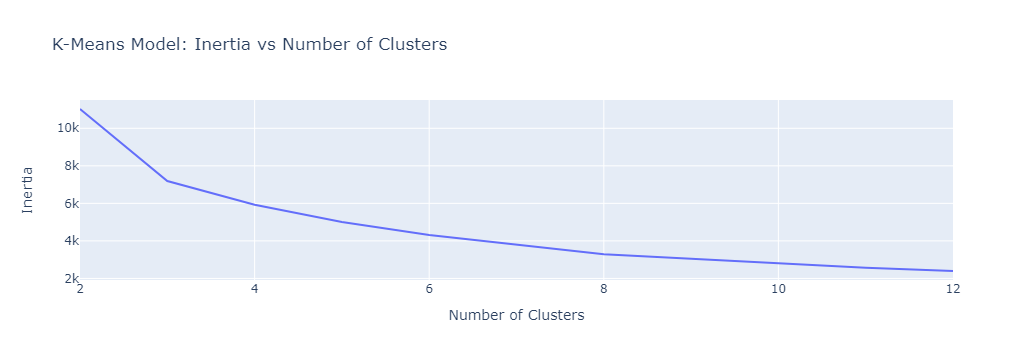

In [50]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

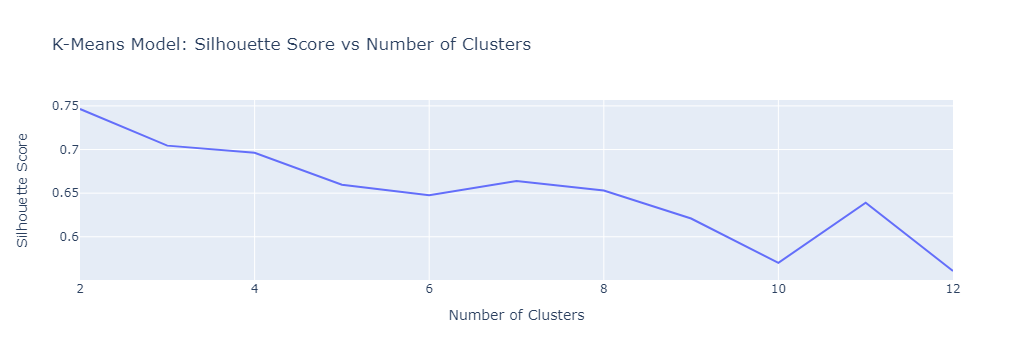

In [51]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")
fig.show()

In [52]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4, random_state=42)
)
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

# Communicate

In [53]:
labels = final_model.named_steps["kmeans"].labels_
print(labels[:5])

[0 0 0 0 0]


In [54]:
xgb = X.groupby(labels).mean()
xgb

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,26551.075439,13676.153182,13745.637777,2.722605e+04,4.022723e+04
1,218112.818182,174713.441558,257403.246753,3.305884e+05,3.928263e+05
2,116160.779817,965764.155963,264339.449541,7.800611e+05,1.081925e+06
3,732937.575758,760397.575758,826136.363636,1.276227e+06,1.493335e+06


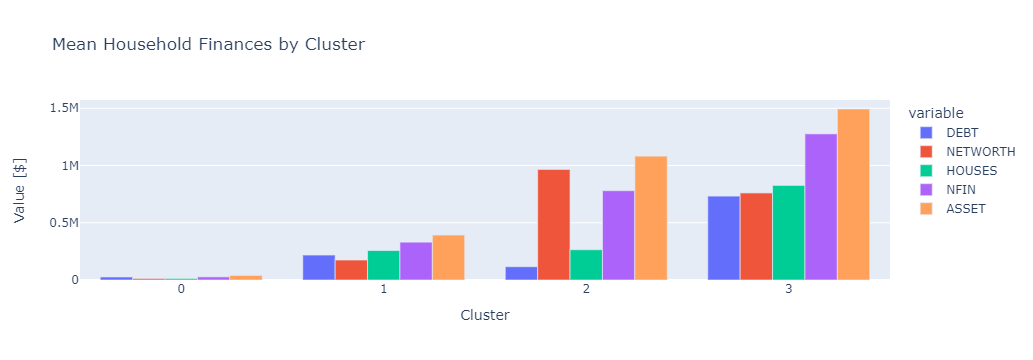

In [55]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Mean Household Finances by Cluster"
)
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")
fig.show()

In [56]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4418, 2)


,PC1,PC2
0,-221525.424530,-22052.273003
1,-217775.100722,-22851.358068
2,-219519.642175,-19023.646333
3,-212195.720367,-22957.107039
4,-215540.507551,-20259.749306


So there we go: our five dimensions have been reduced to two. Let's make a scatter plot and see what we get.

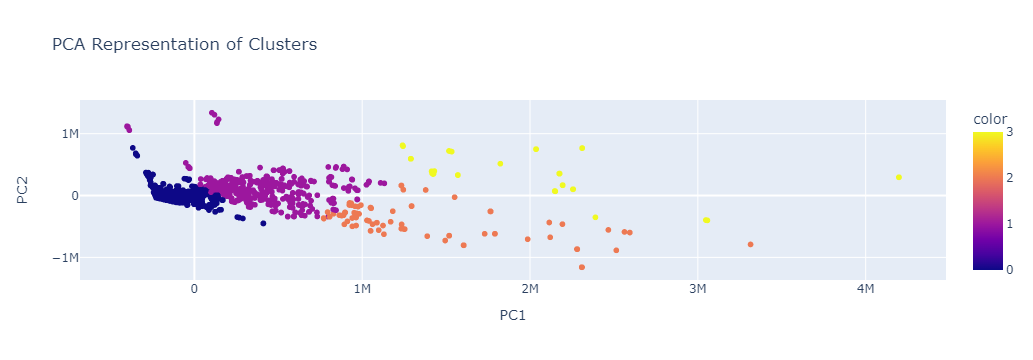

In [57]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels,
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()